## 1. 필요 라이브러러 임포트 및 다운로드

In [10]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------

import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
import random
import os

# 재현성 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 데이터 로딩 함수 정의

In [14]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=200):
    X_list, y_list = [], []
    with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    filename = parts[1]
                    label = parts[-1]
                    fp = os.path.join(audio_path, filename)
                    if not os.path.isfile(fp):
                        continue
                    try:
                        audio, sr = librosa.load(fp, sr=16000)
                        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T # 기존의 13차원에서 20차원으로 변경
                        if mfcc.shape[0] < max_len:
                            mfcc = np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)), mode='constant')
                        else:
                            mfcc = mfcc[:max_len]
                        X_list.append(mfcc)
                        y_list.append(0 if label == 'Real' else 1)
                    except:
                        continue

    return np.array(X_list), np.array(y_list)
from sklearn.preprocessing import StandardScaler
def standardize(X):
    ns, nt, nf = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler

## DNN 모델 정의

In [39]:
def build_dnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## 학습용 데이터 로딩

In [12]:
train_audio_path = '2501ml_data/train'
train_label_path = '2501ml_data/label/train_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [40]:
max_len = 4000
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

# 모델 학습

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=41
)

model = build_dnn_model(input_shape=(max_len, X.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7461 - loss: 1.3222 - val_accuracy: 0.9787 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9679 - loss: 0.1133 - val_accuracy: 0.9850 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9793 - loss: 0.0697 - val_accuracy: 0.9850 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9829 - loss: 0.0495 - val_accuracy: 0.9887 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9870 - loss: 0.0337 - val_accuracy: 0.9862 - val_loss: 0.0511 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9912 - loss: 0.0303 - val_accuracy: 0.9875 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9899 - loss: 0.

## 모델 학습 과정 시각화

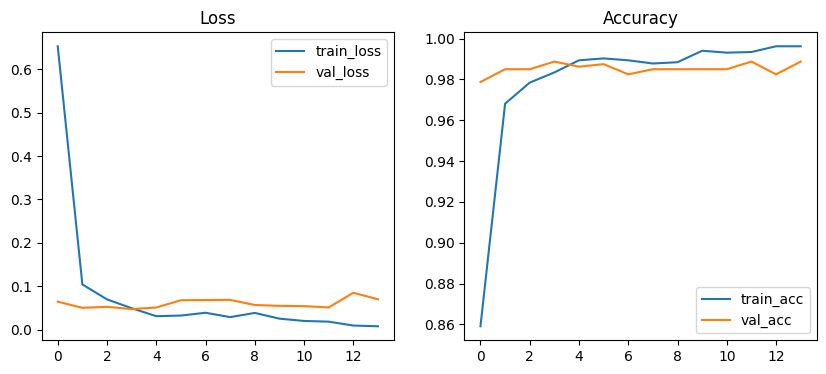

In [54]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)
model.save("dnn_model.h5")

# 테스트 데이터 로딩 및 평가

In [19]:
test_audio_path = '2501ml_data/test'
test_label_path = '2501ml_data/label/test_label.txt'

In [55]:
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)

ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.85      1.00      0.92      1000
        Fake       1.00      0.82      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000

ROC AUC: 0.912


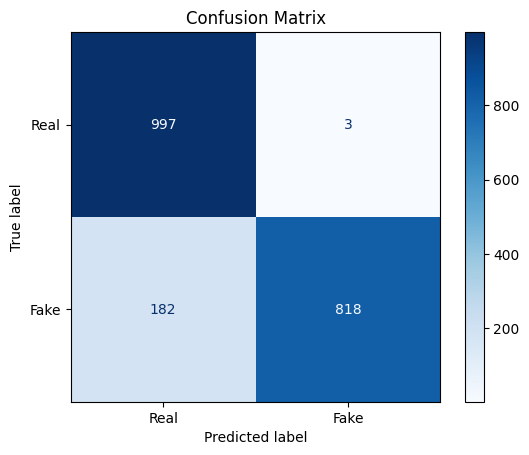

In [56]:
# -------------------------------------------
# 6. 테스트 데이터 평가
# -------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측
y_prob = model.predict(X_test)
y_pred_classes = (y_prob > 0.8).astype(int)

# 리포트 출력
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred_classes, target_names=['Real', 'Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Spectral_Contrast 특징 활용 모델
- 오분류된 데이터에 대해서 따로 특징을 추출하여 분류를 시도함. 이를 활용하여 약 1% 성능 향상이 가능하였음.

In [57]:
def predict_with_spectral_contrast(model,X_test, score:float = 0.32):
    # 🔹 1. DNN 예측
    y_prob = model.predict(X_test).flatten()

    # 🔹 2. 보정 대상: 확률이 낮은 샘플
    uncertain_idx = np.where(y_prob < score)[0]

    # 🔹 3. test_label.txt에서 파일 이름과 라벨 수동 파싱
    test_filenames = []

    y_test = []
    with open(test_label_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                test_filenames.append(parts[1])
                label = 0 if parts[4] == 'Real' else 1
                y_test.append(label)
    
    y_test = np.array(y_test, dtype=int)

    # 🔹 4. Spectral contrast 기반 보정
    for idx in uncertain_idx:
        filename = test_filenames[idx]
        file_path = os.path.join(test_audio_path, filename)

        try:
            y, sr = librosa.load(file_path, sr=16000)
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            high_contrast = np.mean(contrast[-2:, :])  # 고주파 2대역 평균

            if (high_contrast < 21.0 or high_contrast > 27.0):
                y_prob[idx] = 1.0  # Fake로 강제 보정
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")
    return y_prob

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.87      0.99      0.93      1000
        Fake       0.99      0.85      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000

ROC AUC: 0.923


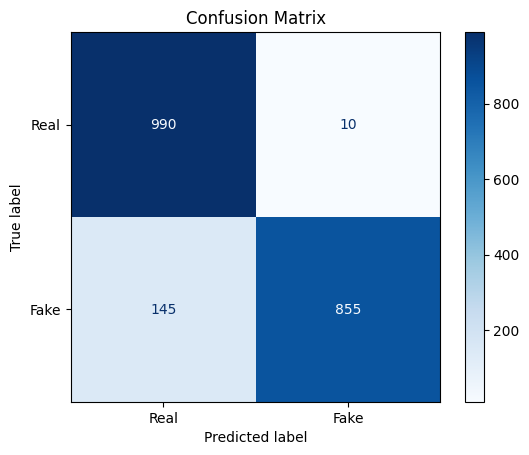

In [58]:
# 🔹 5. 최종 이진 판정 (확률 기준은 0.5 유지)
y_prob = predict_with_spectral_contrast(model,X_test, score=0.5)
y_pred = (y_prob >= 0.5).astype(int)

# 리포트 출력
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 예측 결과 파일 작성

In [ ]:

from sklearn.preprocessing import LabelEncoder
# 1. test 파일명 리스트 로딩
def get_test_filenames(label_path):
    filenames = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                filenames.append(parts[1])
    return filenames

# 2. LabelEncoder: Fake → 0, Real → 1
le = LabelEncoder()
le.fit(['Fake', 'Real']) # 반드시 이 순서로 지정해야 0=Fake, 1=Real

# 3. 파일 이름 로드
test_file_names = get_test_filenames(test_label_path)

# 4. 예측 확률 → 클래스 (0 또는 1) => 정규화 방식에 따라 정확도가 차이가 남.
y_pred_prob =predict_with_spectral_contrast(model,X_test, score=0.5)
# y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_pred_classes = (y_pred_prob <= 0.5).astype(int).flatten()  # 확률 → 0 or 1


# 5. 예측 결과 파일 작성
with open('./team_test_result.txt', 'w', encoding='cp949') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]  # 0 → Fake, 1 → Real
        f.write(f"{test_file_names[i]} {label_str}\n")

print("✅ team_test_result.txt 저장 완료 (Perl 평가용)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ team_test_result.txt 저장 완료 (Perl 평가용)


In [38]:
!perl /content/drive/MyDrive/2501ml_data/eval.pl ./team_test_result.txt /content/drive/MyDrive/2501ml_data/label/test_label.txt

'perl'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
